In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import trumps_no_pile as tnp
from collections import deque
import torchbnn as bnn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import helpers
%matplotlib inline

In [2]:
env = tnp.SuperTrumps()
s, pc = env.reset()
n_obs = env.observation_space[0]
n_actions = env.action_space

In [3]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=1, prior_sigma=0.1,
                    in_features=n_obs, out_features=n_obs),
    nn.ELU(),
    bnn.BayesLinear(prior_mu=1, prior_sigma=0.1,
                    in_features=n_obs, out_features=n_actions)
)

In [4]:
def get_action_epsilon(state, epsilon, n_samples=50):
    '''States will be an observation'''
    # Reward values for each state
    state_values = np.stack([
        model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
        for _ in range(n_samples)])

    average_q_values = state_values.mean(axis=0)

    best_action = average_q_values.argmax(axis=-1)
    if np.random.rand(1) < epsilon:

        rn = np.random.randint(1, 52)
        return rn, average_q_values[rn]

    else:
        return best_action, average_q_values[best_action]


def get_action_upper_quartile(state, n_samples=50):
    '''States will be an observation'''
    # Reward values for each state
    state_values = np.stack([
        model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
        for _ in range(n_samples)])

    quantile_values = np.quantile(state_values, 0.75, axis=0)

    best_action = quantile_values.argmax(axis=-1)
    return best_action, quantile_values[best_action]


def get_action_thompson(state):

    q_values = model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
    action = np.argmax(q_values, axis=-1)
    return action, q_values[action]

In [5]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
opt = optim.Adam(model.parameters(), lr=1e-2)

In [7]:
max_epsiodes = 40000
gamma = 0.99
mses = []
all_rewards = []

for episode in range(1, max_epsiodes):
    s, pc = env.reset()
    done = False
    total_reward = 0
    qvs = []  # q values
    rewards = []
    while not done:
        a, qv = get_action_thompson(s)
        ns, r, done, pc = env.step(a)

        rewards.append(r)
        qvs.append(qv)
        s = ns
        total_reward += r
        if done:
            all_rewards.append(total_reward)
            break

    yvals = np.zeros_like(rewards)
    x = 0
    for i in reversed(range(len(rewards))):
        x = rewards[i] + x*gamma
        yvals[i] = x

    mse = ((np.array(qvs)-yvals)**2).sum()
    kl = kl_loss(model)
    loss = mse + kl_weight*kl

    opt.zero_grad()
    loss.backward()
    opt.step()
    mses.append(mse)
    if episode % 5000 == 0 :
        print(f' Avg reward: {np.mean(all_rewards[-990:]):.2f}')

 Avg reward: -0.96
 Avg reward: -0.96
 Avg reward: -0.98
 Avg reward: -0.96
 Avg reward: -0.95
 Avg reward: -0.96
 Avg reward: -0.96


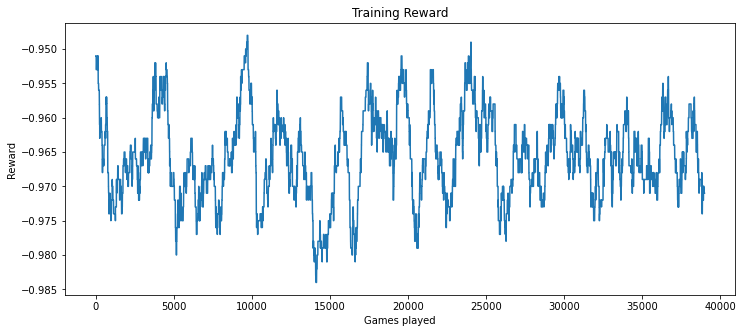

In [8]:
helpers.plot_training_graph(all_rewards)